In [1]:
# This cell will prompt you to connect this notebook with your google account.
from google.colab import drive                                                                        
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Docencia/art_JDPJ/en_proceso/letter_pedestrians/model/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Setup

In [66]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

print('Libraries read!')


Libraries read!


# Data processing and exploration

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv(base_dir + 'processed_df_run_over_onehot.csv').iloc[:,1:]
raw_df.head()


,type_road_intersection,type_road_land_lot,type_road_other,type_road_track_section,climate_wet,weekend_yes,night_yes,street_use_one_way,street_use_other,street_use_two_ways,number_roads_one_road,number_roads_other,number_roads_two_roads,number_lanes_one_lane,number_lanes_other,number_lanes_two_lanes,rolling_surface_other,status_road_bad,illumination_bad,traffic_light_bad,vertical_signals_bad,horizontal_signals_bad,visibility_bad,type_vehicle_car,type_vehicle_motorcycle,type_vehicle_other,month_dry_no,humidity_road_other,severity
0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,False
1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,False
2,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,False
3,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,False
4,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,False


In [4]:
raw_df.shape

(33479, 29)

In [5]:
raw_df.dtypes

type_road_intersection     int64
type_road_land_lot         int64
type_road_other            int64
type_road_track_section    int64
climate_wet                int64
weekend_yes                int64
night_yes                  int64
street_use_one_way         int64
street_use_other           int64
street_use_two_ways        int64
number_roads_one_road      int64
number_roads_other         int64
number_roads_two_roads     int64
number_lanes_one_lane      int64
number_lanes_other         int64
number_lanes_two_lanes     int64
rolling_surface_other      int64
status_road_bad            int64
illumination_bad           int64
traffic_light_bad          int64
vertical_signals_bad       int64
horizontal_signals_bad     int64
visibility_bad             int64
type_vehicle_car           int64
type_vehicle_motorcycle    int64
type_vehicle_other         int64
month_dry_no               int64
humidity_road_other        int64
severity                    bool
dtype: object

In [6]:
raw_df.describe(include='all')


,type_road_intersection,type_road_land_lot,type_road_other,type_road_track_section,climate_wet,weekend_yes,night_yes,street_use_one_way,street_use_other,street_use_two_ways,number_roads_one_road,number_roads_other,number_roads_two_roads,number_lanes_one_lane,number_lanes_other,number_lanes_two_lanes,rolling_surface_other,status_road_bad,illumination_bad,traffic_light_bad,vertical_signals_bad,horizontal_signals_bad,visibility_bad,type_vehicle_car,type_vehicle_motorcycle,type_vehicle_other,month_dry_no,humidity_road_other,severity
count,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479.000000,33479
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33090
mean,0.068102,0.054273,0.008304,0.869321,0.034230,0.306192,0.291078,0.627737,0.015950,0.356313,0.838735,0.023358,0.137907,0.372233,0.129185,0.498581,0.001225,0.007019,0.186176,0.004839,0.070522,0.057768,0.956928,0.313420,0.572538,0.114042,0.839661,0.041339,NaN
std,0.251925,0.226559,0.090747,0.337054,0.181823,0.460917,0.454266,0.483415,0.125285,0.478916,0.367781,0.151040,0.344808,0.483407,0.335410,0.500005,0.034974,0.083488,0.389255,0.069394,0.256028,0.233307,0.203022,0.463891,0.494718,0.317867,0.366926,0.199077,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN
75%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,NaN


# Examine the class label imbalance

## Let's look at the dataset imbalance:

In [7]:
neg, pos = np.bincount(raw_df['severity'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 33479
    Positive: 389 (1.16% of total)



This shows the "small" fraction of positive samples (serious_accidents).

# Split and normalize the data

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

In [8]:
cleaned_df = raw_df.copy()

In [9]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2, stratify=cleaned_df['severity'])
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['severity'])

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('severity'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('severity'))
test_labels = np.array(test_df.pop('severity'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

**Note:** The StandardScaler is only fit using the train_features to be sure the model is not peeking at the validation or test sets. 

In [10]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (21426,)
Validation labels shape: (5357,)
Test labels shape: (6696,)
Training features shape: (21426, 28)
Validation features shape: (5357, 28)
Test features shape: (6696, 28)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.

# Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns the probability of an accident being fatal: 

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
                            ])
        
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics
                 )

    return model

## Understanding useful metrics


Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.

- False negatives and false positives are samples that were incorrectly classified
- True negatives and true positives are samples that were correctly classified
- Accuracy is the percentage of examples correctly classified > $$ true samples / total samples $$
- Precision is the percentage of predicted positives that were correctly classified > $$ true positives / (true positives + false positives) $$
- Recall is the percentage of actual positives that were correctly classified > $$ true positives / (true positives + false negatives) $$
- AUC refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than than a random negative sample.

**Note:** Accuracy is not a helpful metric for this task. You can 73.1%+ accuracy on this task by predicting False all the time. 

# Baseline model

## Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.

**Note:** this model will not handle the class imbalance well. We will improve it later.

In [12]:
EPOCHS = 1000
BATCH_SIZE = 4096

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [13]:
model = make_model()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


### Test run the model:

In [14]:
model.predict(train_features)


array([[0.47983715],
       [0.30515677],
       [0.2538794 ],
       ...,
       [0.0887433 ],
       [0.30384332],
       [0.10656725]], dtype=float32)

### Optional: Set the correct initial bias.

These are initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: A Recipe for Training Neural Networks: "init well"). This can help with initial convergence.

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.3504


The correct bias to set can be derived from:

$$ p0 = pos/(pos + neg) = 1/(1+exp(-b0)) $$
$$ b0 = -loge(1/(p0-1) $$
$$ b0 = loge(pos/neg) $$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-4.44340706])

Set that as the initial bias, and the model will give much more reasonable initial guesses.

In [17]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])


array([[0.00639793],
       [0.01690465],
       [0.01425549],
       [0.01001835],
       [0.01327786],
       [0.01535264],
       [0.00695872],
       [0.0043557 ],
       [0.00660819],
       [0.00851535]], dtype=float32)

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0634


This initial loss is less than if would have been with naive initilization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

## Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)


## Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [22]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()


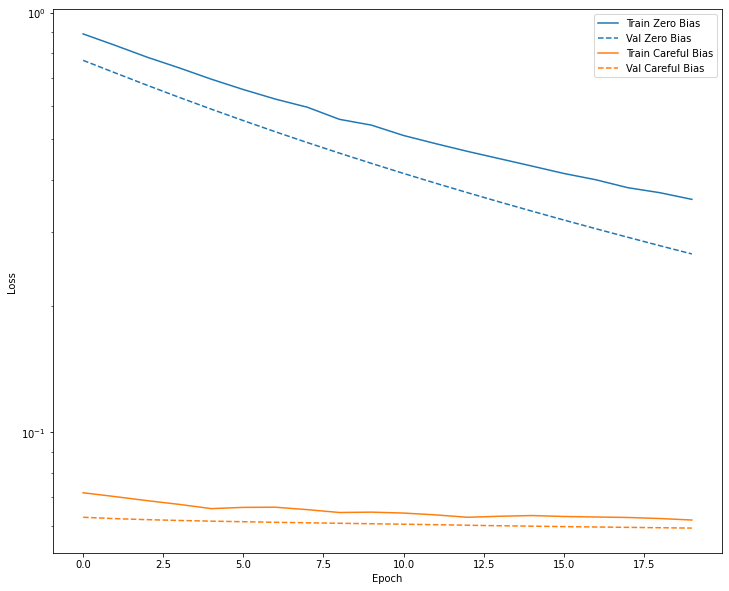

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)


The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

## Train the model

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))


Epoch 1/1000
6/6 [==============================] - 1s 141ms/step - loss: 0.0727 - tp: 1.0000 - fp: 57.0000 - tn: 26415.0000 - fn: 310.0000 - accuracy: 0.9863 - precision: 0.0172 - recall: 0.0032 - auc: 0.6156 - val_loss: 0.0628 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5295.0000 - val_fn: 62.0000 - val_accuracy: 0.9884 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6175
Epoch 2/1000
6/6 [==============================] - 0s 20ms/step - loss: 0.0699 - tp: 0.0000e+00 - fp: 28.0000 - tn: 21149.0000 - fn: 249.0000 - accuracy: 0.9871 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5718 - val_loss: 0.0624 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5295.0000 - val_fn: 62.0000 - val_accuracy: 0.9884 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6378
Epoch 3/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0679 - tp: 2.0000 - fp: 25.0000 - tn: 21152.0000 - fn: 247.0000 - accuracy: 0.9873 - precision: 0.0741 - rec

## Check training history

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [25]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.5,1])
        else:
            plt.ylim([0,1])

        plt.legend()


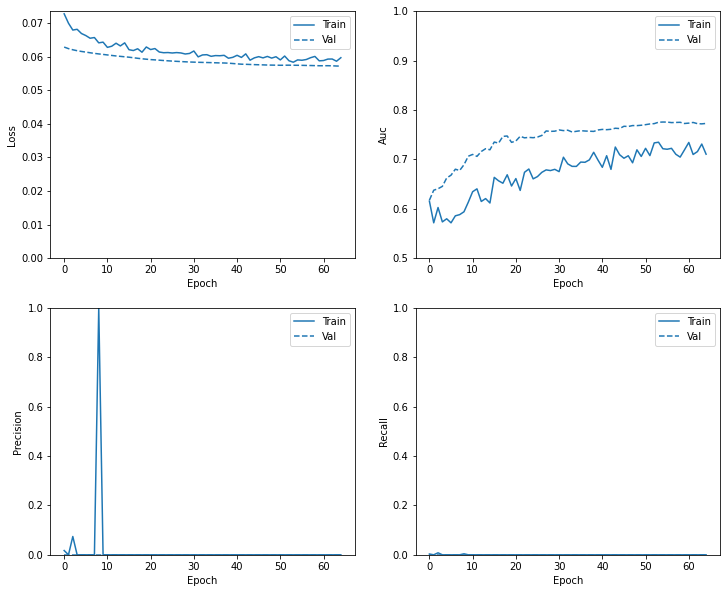

In [26]:
plot_metrics(baseline_history)


**Note:** That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

## Evaluate metrics

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)


In [28]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Injuries Detected (True Negatives): ', cm[0][0])
    print('Injuries Incorrectly Detected (False Positives): ', cm[0][1])
    print('Deaths Missed (False Negatives): ', cm[1][0])
    print('Deaths Detected (True Positives): ', cm[1][1])
    print('Total Victims: ', np.sum(cm[1]))


Evaluate your model on the test dataset and display the results for the metrics you created above.

loss :  0.05823920667171478
tp :  0.0
fp :  0.0
tn :  6618.0
fn :  78.0
accuracy :  0.9883512258529663
precision :  0.0
recall :  0.0
auc :  0.7600580453872681

Injuries Detected (True Negatives):  6618
Injuries Incorrectly Detected (False Positives):  0
Deaths Missed (False Negatives):  78
Deaths Detected (True Positives):  0
Total Victims:  78


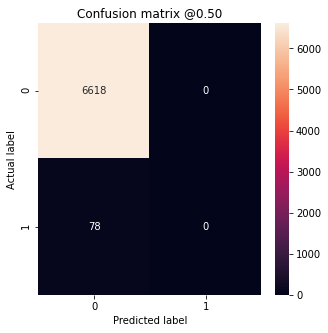

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)


If the model had predicted everything perfectly, this would be a diagonal matrix where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

## Plot the ROC

Now plot the ROC. This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,70])
    plt.ylim([30,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


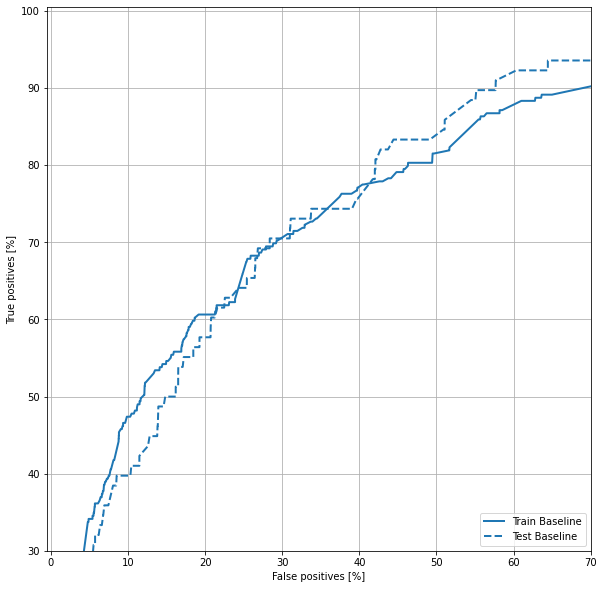

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')


It looks like the precision is relatively low, and the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent non-serious accident) may have a cost, while a false positive (a serious accident is incorrectly flagged as non-serious) may generate a possible death of the victim.

# Class weights

## Calculate class weights

The goal is to identify serious accidents, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [32]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.51
Weight for class 1: 43.03


## Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

**Note:** Using class_weights changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like **optimizers.SGD**, may fail. The optimizer used here, **optimizers.Adam**, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [33]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/1000
6/6 [==============================] - 1s 171ms/step - loss: 2.0180 - tp: 3.0000 - fp: 66.0000 - tn: 27729.0000 - fn: 324.0000 - accuracy: 0.9861 - precision: 0.0435 - recall: 0.0092 - auc: 0.6114 - val_loss: 0.0638 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5295.0000 - val_fn: 62.0000 - val_accuracy: 0.9884 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6205
Epoch 2/1000
6/6 [==============================] - 0s 20ms/step - loss: 1.9889 - tp: 1.0000 - fp: 67.0000 - tn: 21110.0000 - fn: 248.0000 - accuracy: 0.9853 - precision: 0.0147 - recall: 0.0040 - auc: 0.5557 - val_loss: 0.0642 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5295.0000 - val_fn: 62.0000 - val_accuracy: 0.9884 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6294
Epoch 3/1000
6/6 [==============================] - 0s 21ms/step - loss: 1.9083 - tp: 5.0000 - fp: 88.0000 - tn: 21089.0000 - fn: 244.0000 - accuracy: 0.9845 - precision: 0.0538 - recall: 0.0201 

## Check training history

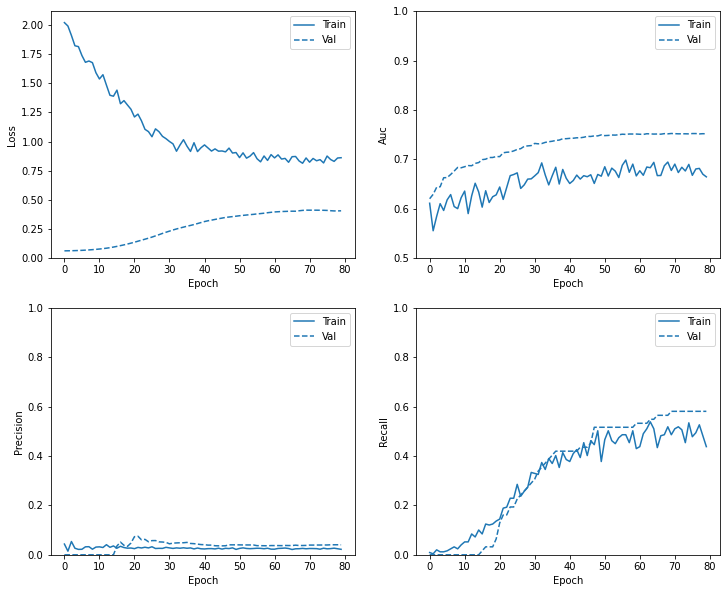

In [34]:
plot_metrics(weighted_history)


## Evaluate metrics

In [35]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)


loss :  0.4102185368537903
tp :  37.0
fp :  1132.0
tn :  5486.0
fn :  41.0
accuracy :  0.8248208165168762
precision :  0.031650982797145844
recall :  0.4743589758872986
auc :  0.7352442145347595

Injuries Detected (True Negatives):  5486
Injuries Incorrectly Detected (False Positives):  1132
Deaths Missed (False Negatives):  41
Deaths Detected (True Positives):  37
Total Victims:  78


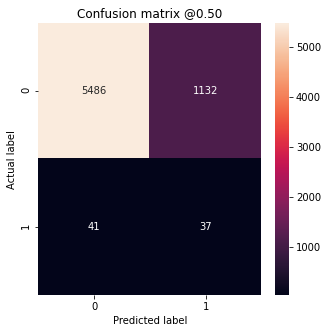

In [36]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)



Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade offs between these different types of errors for your application.


## Plot the ROC

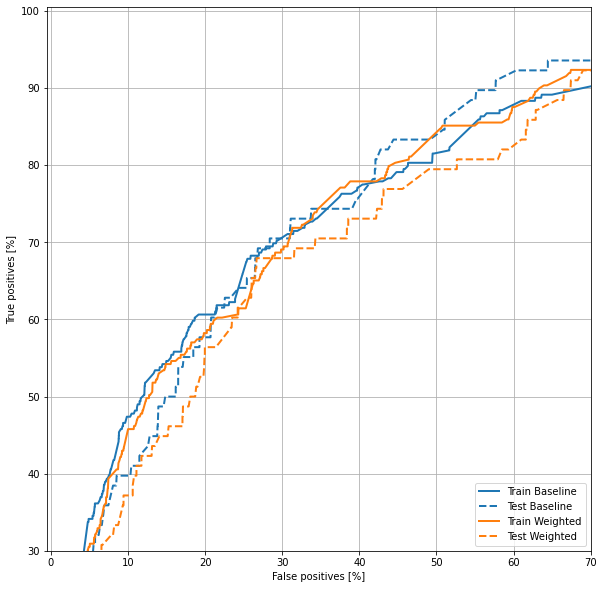

In [37]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')



# Oversampling

## Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [38]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]


Using NumPy

You can balance the dataset manually by choosing the right number of random indices from the positive examples:

In [39]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(21177, 28)

In [40]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(42354, 28)

**Using tf.data**

If you're using tf.data the easiest way to produce balanced examples is to start with a positive and a negative dataset, and merge them. See the tf.data guide for more examples.



In [41]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)


Each dataset provides (feature, label) pairs:

In [42]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())


Features:
 [-0.26611676 -0.23880974 -0.0902221   0.38340858 -0.18966631 -0.66450456
 -0.64036638  0.77184191 -0.12526341 -0.74655774  0.4386193  -0.15599447
 -0.39942593  1.31033079 -0.38811903 -1.00205569 -0.03278133 -0.08646602
  2.11225863 -0.06673539 -0.2723974  -0.24518519  0.20695584 -0.67188492
 -1.16028226  2.77155615  0.43475534 -0.2098816 ]

Label:  True


Merge the two together using **experimental.sample_from_datasets**:

In [43]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)


In [44]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())


0.49169921875


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [45]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

17.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

**Note:** Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [46]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)


Epoch 1/1000
17/17 [==============================] - 2s 90ms/step - loss: 0.7411 - tp: 22978.0000 - fp: 20365.0000 - tn: 21198.0000 - fn: 11787.0000 - accuracy: 0.5788 - precision: 0.5301 - recall: 0.6610 - auc: 0.6249 - val_loss: 0.7409 - val_tp: 44.0000 - val_fp: 2677.0000 - val_tn: 2618.0000 - val_fn: 18.0000 - val_accuracy: 0.4969 - val_precision: 0.0162 - val_recall: 0.7097 - val_auc: 0.6832
Epoch 2/1000
17/17 [==============================] - 1s 48ms/step - loss: 0.7067 - tp: 22468.0000 - fp: 16679.0000 - tn: 18151.0000 - fn: 12334.0000 - accuracy: 0.5833 - precision: 0.5739 - recall: 0.6456 - auc: 0.6148 - val_loss: 0.6869 - val_tp: 47.0000 - val_fp: 2061.0000 - val_tn: 3234.0000 - val_fn: 15.0000 - val_accuracy: 0.6125 - val_precision: 0.0223 - val_recall: 0.7581 - val_auc: 0.7275
Epoch 3/1000
17/17 [==============================] - 1s 48ms/step - loss: 0.6808 - tp: 22393.0000 - fp: 15000.0000 - tn: 19796.0000 - fn: 12443.0000 - accuracy: 0.6059 - precision: 0.5989 - recall:

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

## Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

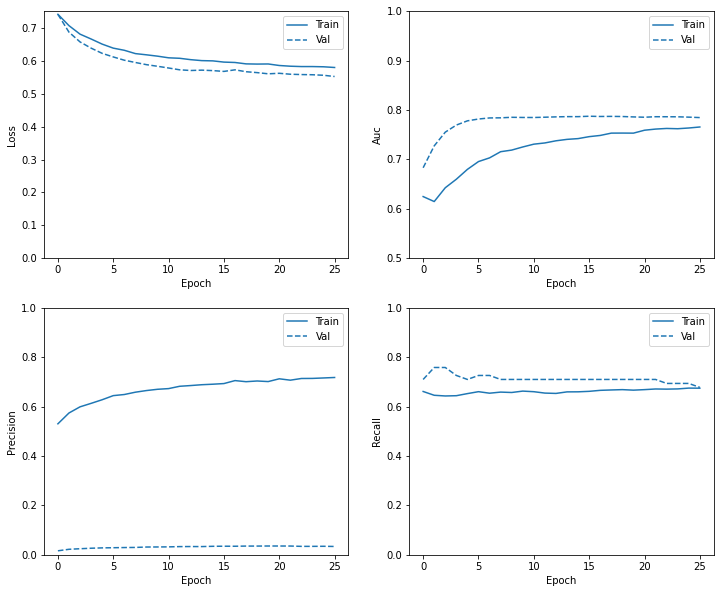

In [47]:
plot_metrics( resampled_history )


## Re-train

Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the **callbacks.EarlyStopping** finer control over when to stop training.

In [48]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


Epoch 1/10000
20/20 [==============================] - 2s 96ms/step - loss: 0.7363 - tp: 26848.0000 - fp: 23669.0000 - tn: 22820.0000 - fn: 13940.0000 - accuracy: 0.5691 - precision: 0.5315 - recall: 0.6582 - auc: 0.6068 - val_loss: 0.7289 - val_tp: 45.0000 - val_fp: 2493.0000 - val_tn: 2802.0000 - val_fn: 17.0000 - val_accuracy: 0.5315 - val_precision: 0.0177 - val_recall: 0.7258 - val_auc: 0.6959
Epoch 2/10000
20/20 [==============================] - 1s 44ms/step - loss: 0.7001 - tp: 26457.0000 - fp: 18953.0000 - tn: 21863.0000 - fn: 14647.0000 - accuracy: 0.5898 - precision: 0.5826 - recall: 0.6437 - auc: 0.6202 - val_loss: 0.6749 - val_tp: 47.0000 - val_fp: 2001.0000 - val_tn: 3294.0000 - val_fn: 15.0000 - val_accuracy: 0.6237 - val_precision: 0.0229 - val_recall: 0.7581 - val_auc: 0.7388
Epoch 3/10000
20/20 [==============================] - 1s 44ms/step - loss: 0.6743 - tp: 26501.0000 - fp: 17248.0000 - tn: 23653.0000 - fn: 14518.0000 - accuracy: 0.6122 - precision: 0.6058 - reca

## Re-check training history

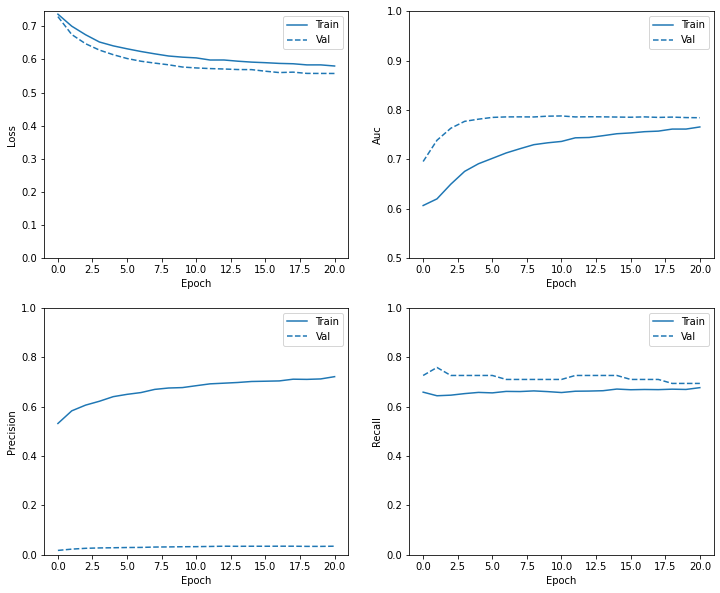

In [49]:
plot_metrics(resampled_history)


## Evaluate metrics

In [50]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)


loss :  0.5733189582824707
tp :  52.0
fp :  1650.0
tn :  4968.0
fn :  26.0
accuracy :  0.7497013211250305
precision :  0.030552292242646217
recall :  0.6666666865348816
auc :  0.7738306522369385

Injuries Detected (True Negatives):  4968
Injuries Incorrectly Detected (False Positives):  1650
Deaths Missed (False Negatives):  26
Deaths Detected (True Positives):  52
Total Victims:  78


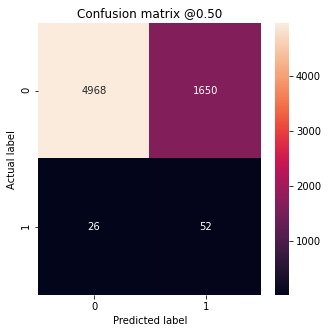

In [51]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)



## Plot the ROC

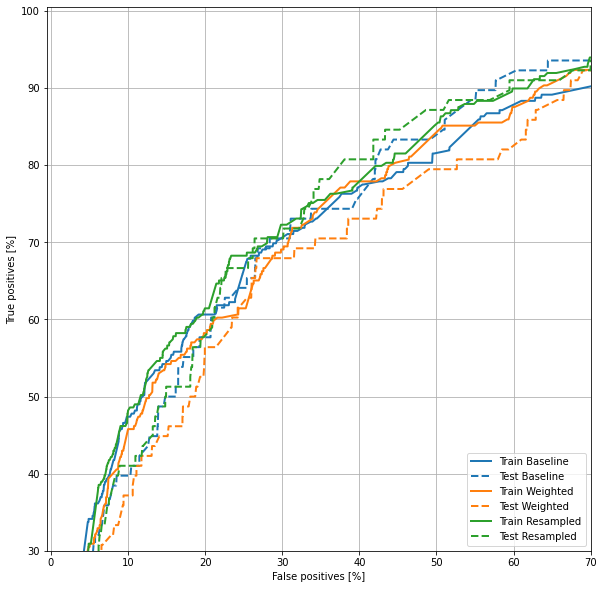

In [52]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')



# HYPERPARAMETER TUNING USING SKLEARN

## Re-train

Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the **callbacks.EarlyStopping** finer control over when to stop training.

Epoch 1/10000
20/20 [==============================] - 2s 81ms/step - loss: 0.7390 - tp: 26924.0000 - fp: 24033.0000 - tn: 23779.0000 - fn: 13880.0000 - accuracy: 0.5722 - precision: 0.5284 - recall: 0.6598 - auc: 0.6087 - val_loss: 0.7281 - val_tp: 44.0000 - val_fp: 2491.0000 - val_tn: 2804.0000 - val_fn: 18.0000 - val_accuracy: 0.5316 - val_precision: 0.0174 - val_recall: 0.7097 - val_auc: 0.6948
Epoch 2/10000
20/20 [==============================] - 1s 44ms/step - loss: 0.6972 - tp: 26368.0000 - fp: 18700.0000 - tn: 22116.0000 - fn: 14736.0000 - accuracy: 0.5918 - precision: 0.5851 - recall: 0.6415 - auc: 0.6247 - val_loss: 0.6733 - val_tp: 47.0000 - val_fp: 1992.0000 - val_tn: 3303.0000 - val_fn: 15.0000 - val_accuracy: 0.6253 - val_precision: 0.0231 - val_recall: 0.7581 - val_auc: 0.7380
Epoch 3/10000
20/20 [==============================] - 1s 46ms/step - loss: 0.6731 - tp: 26418.0000 - fp: 17109.0000 - tn: 23792.0000 - fn: 14601.0000 - accuracy: 0.6129 - precision: 0.6069 - reca

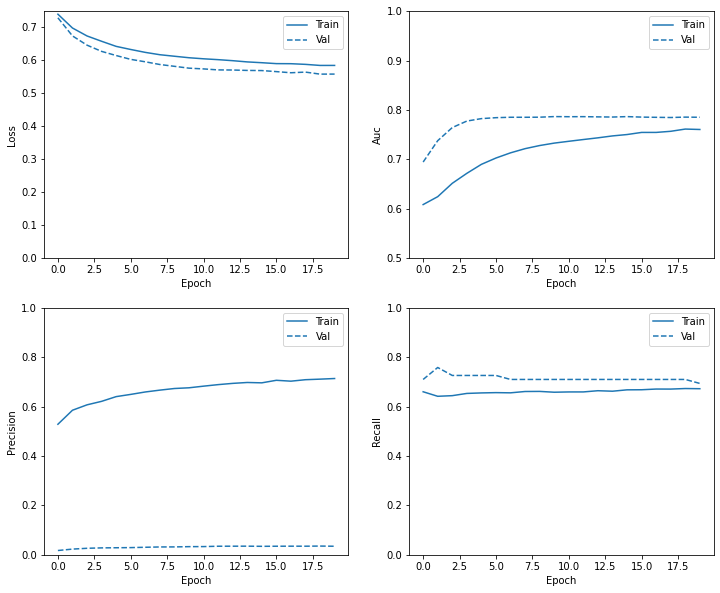

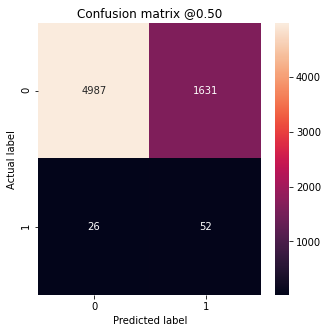

In [53]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
                            ])
        
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics
                 )

    return model



# Re-training

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


# Re-check training history
plot_metrics(resampled_history)


# Evaluate metrics

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Epoch 1/10000
20/20 [==============================] - 2s 87ms/step - loss: 0.7197 - tp: 23752.0000 - fp: 20355.0000 - tn: 27457.0000 - fn: 17052.0000 - accuracy: 0.5779 - precision: 0.5385 - recall: 0.5821 - auc: 0.6013 - val_loss: 0.6700 - val_tp: 41.0000 - val_fp: 1948.0000 - val_tn: 3347.0000 - val_fn: 21.0000 - val_accuracy: 0.6324 - val_precision: 0.0206 - val_recall: 0.6613 - val_auc: 0.6951
Epoch 2/10000
20/20 [==============================] - 1s 46ms/step - loss: 0.6851 - tp: 24974.0000 - fp: 16725.0000 - tn: 24091.0000 - fn: 16130.0000 - accuracy: 0.5989 - precision: 0.5989 - recall: 0.6076 - auc: 0.6333 - val_loss: 0.6490 - val_tp: 44.0000 - val_fp: 1863.0000 - val_tn: 3432.0000 - val_fn: 18.0000 - val_accuracy: 0.6489 - val_precision: 0.0231 - val_recall: 0.7097 - val_auc: 0.7368
Epoch 3/10000
20/20 [==============================] - 1s 47ms/step - loss: 0.6635 - tp: 25708.0000 - fp: 15616.0000 - tn: 25285.0000 - fn: 15311.0000 - accuracy: 0.6225 - precision: 0.6221 - reca

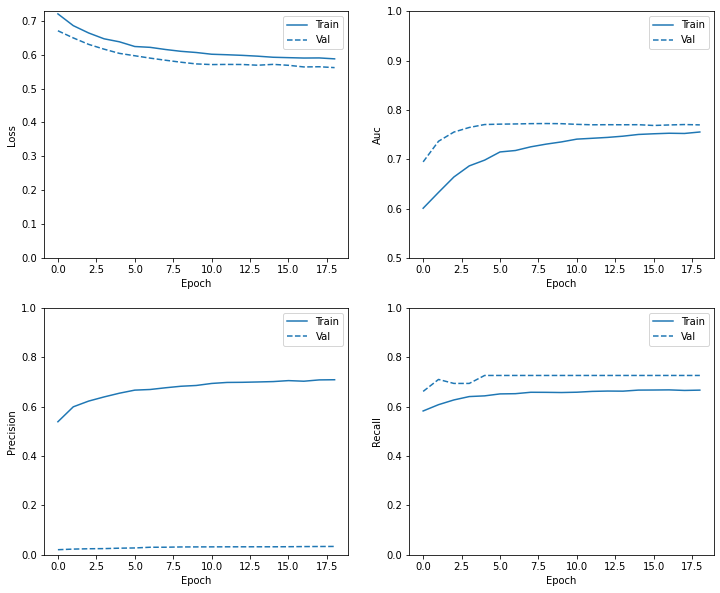

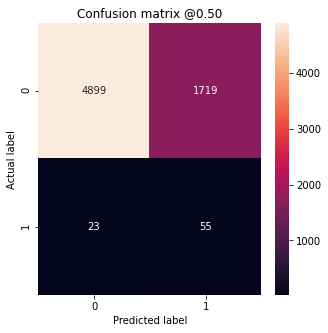

In [54]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='tanh', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
                            ])
        
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics
                 )

    return model



# Re-training

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


# Re-check training history
plot_metrics(resampled_history)


# Evaluate metrics

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Epoch 1/10000
20/20 [==============================] - 2s 82ms/step - loss: 0.7226 - tp: 26104.0000 - fp: 25561.0000 - tn: 22251.0000 - fn: 14700.0000 - accuracy: 0.5457 - precision: 0.5053 - recall: 0.6397 - auc: 0.5704 - val_loss: 0.7205 - val_tp: 50.0000 - val_fp: 3021.0000 - val_tn: 2274.0000 - val_fn: 12.0000 - val_accuracy: 0.4338 - val_precision: 0.0163 - val_recall: 0.8065 - val_auc: 0.6725
Epoch 2/10000
20/20 [==============================] - 1s 45ms/step - loss: 0.7015 - tp: 24620.0000 - fp: 20170.0000 - tn: 20646.0000 - fn: 16484.0000 - accuracy: 0.5526 - precision: 0.5497 - recall: 0.5990 - auc: 0.5727 - val_loss: 0.6756 - val_tp: 42.0000 - val_fp: 1892.0000 - val_tn: 3403.0000 - val_fn: 20.0000 - val_accuracy: 0.6431 - val_precision: 0.0217 - val_recall: 0.6774 - val_auc: 0.7141
Epoch 3/10000
20/20 [==============================] - 1s 45ms/step - loss: 0.6884 - tp: 24215.0000 - fp: 18552.0000 - tn: 22349.0000 - fn: 16804.0000 - accuracy: 0.5684 - precision: 0.5662 - reca

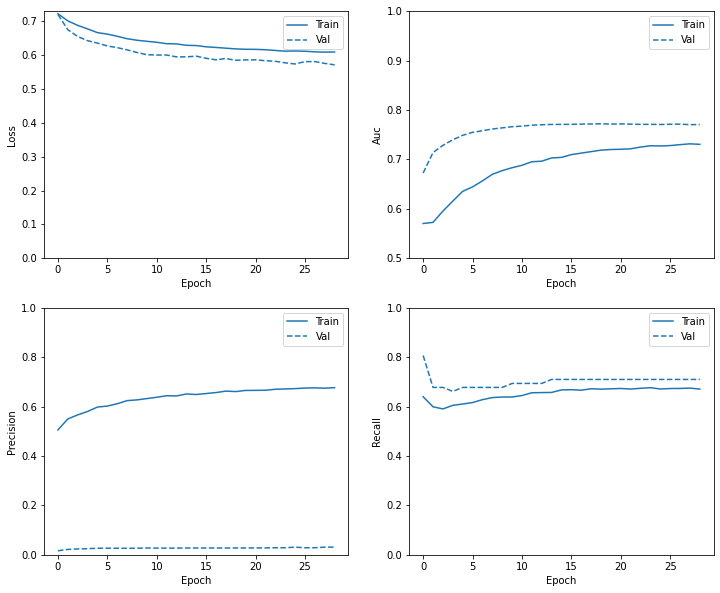

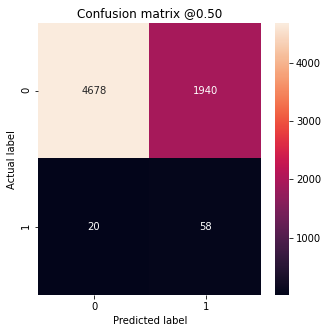

In [55]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='sigmoid', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
                            ])
        
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics
                 )

    return model



# Re-training

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


# Re-check training history
plot_metrics(resampled_history)


# Evaluate metrics

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Epoch 1/10000
20/20 [==============================] - 2s 86ms/step - loss: 0.7263 - tp: 26854.0000 - fp: 23455.0000 - tn: 24357.0000 - fn: 13950.0000 - accuracy: 0.5779 - precision: 0.5338 - recall: 0.6581 - auc: 0.6169 - val_loss: 0.7076 - val_tp: 48.0000 - val_fp: 2396.0000 - val_tn: 2899.0000 - val_fn: 14.0000 - val_accuracy: 0.5501 - val_precision: 0.0196 - val_recall: 0.7742 - val_auc: 0.7144
Epoch 2/10000
20/20 [==============================] - 1s 47ms/step - loss: 0.6879 - tp: 26633.0000 - fp: 18300.0000 - tn: 22516.0000 - fn: 14471.0000 - accuracy: 0.6000 - precision: 0.5927 - recall: 0.6479 - auc: 0.6351 - val_loss: 0.6651 - val_tp: 48.0000 - val_fp: 1938.0000 - val_tn: 3357.0000 - val_fn: 14.0000 - val_accuracy: 0.6356 - val_precision: 0.0242 - val_recall: 0.7742 - val_auc: 0.7526
Epoch 3/10000
20/20 [==============================] - 1s 49ms/step - loss: 0.6629 - tp: 26735.0000 - fp: 16720.0000 - tn: 24181.0000 - fn: 14284.0000 - accuracy: 0.6215 - precision: 0.6152 - reca

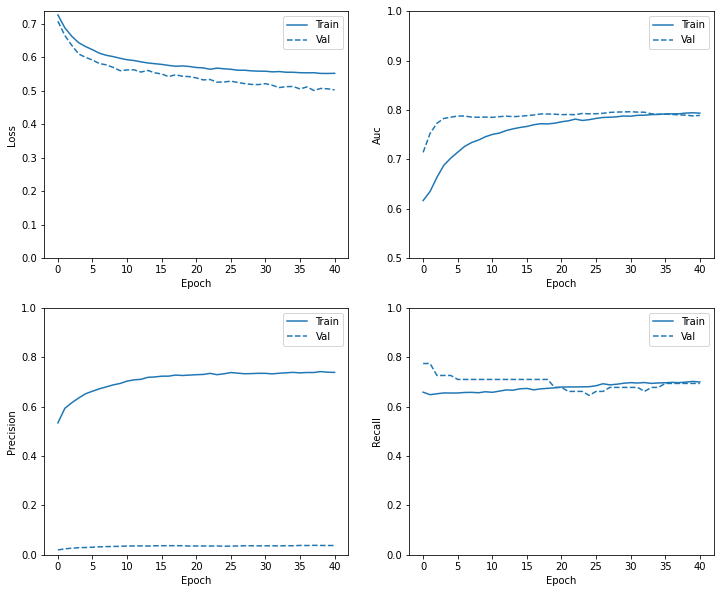

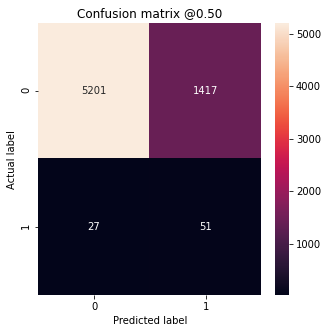

In [56]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
                            ])
        
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics
                 )

    return model



# Re-training

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


# Re-check training history
plot_metrics(resampled_history)


# Evaluate metrics

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Epoch 1/10000
20/20 [==============================] - 2s 85ms/step - loss: 0.7094 - tp: 23950.0000 - fp: 19636.0000 - tn: 28176.0000 - fn: 16854.0000 - accuracy: 0.5882 - precision: 0.5495 - recall: 0.5870 - auc: 0.6196 - val_loss: 0.6595 - val_tp: 42.0000 - val_fp: 1909.0000 - val_tn: 3386.0000 - val_fn: 20.0000 - val_accuracy: 0.6399 - val_precision: 0.0215 - val_recall: 0.6774 - val_auc: 0.7184
Epoch 2/10000
20/20 [==============================] - 1s 44ms/step - loss: 0.6744 - tp: 25563.0000 - fp: 16224.0000 - tn: 24592.0000 - fn: 15541.0000 - accuracy: 0.6122 - precision: 0.6117 - recall: 0.6219 - auc: 0.6494 - val_loss: 0.6416 - val_tp: 44.0000 - val_fp: 1756.0000 - val_tn: 3539.0000 - val_fn: 18.0000 - val_accuracy: 0.6688 - val_precision: 0.0244 - val_recall: 0.7097 - val_auc: 0.7465
Epoch 3/10000
20/20 [==============================] - 1s 46ms/step - loss: 0.6543 - tp: 26138.0000 - fp: 15222.0000 - tn: 25679.0000 - fn: 14881.0000 - accuracy: 0.6325 - precision: 0.6320 - reca

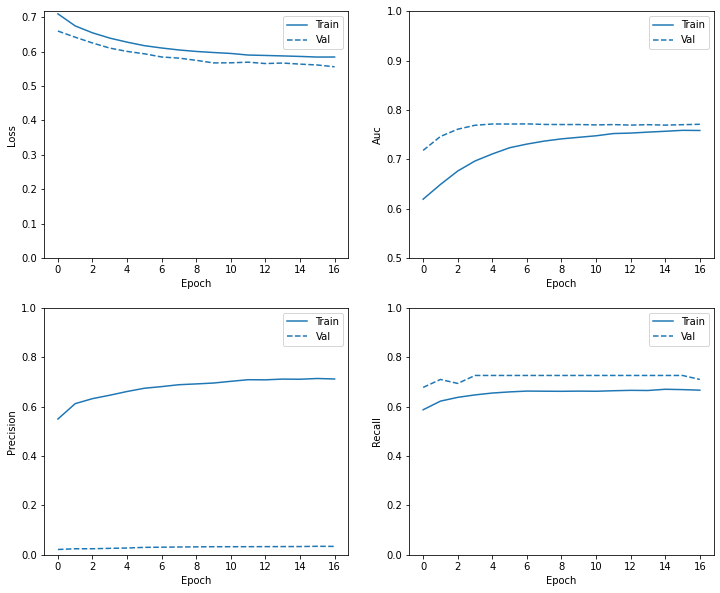

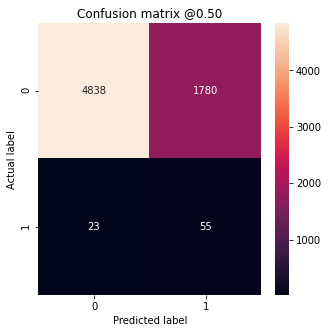

In [57]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='tanh', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
                            ])
        
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics
                 )

    return model



# Re-training

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


# Re-check training history
plot_metrics(resampled_history)


# Evaluate metrics

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Epoch 1/10000
20/20 [==============================] - 2s 96ms/step - loss: 0.7156 - tp: 25594.0000 - fp: 24574.0000 - tn: 23238.0000 - fn: 15210.0000 - accuracy: 0.5511 - precision: 0.5102 - recall: 0.6272 - auc: 0.5773 - val_loss: 0.7026 - val_tp: 48.0000 - val_fp: 2368.0000 - val_tn: 2927.0000 - val_fn: 14.0000 - val_accuracy: 0.5553 - val_precision: 0.0199 - val_recall: 0.7742 - val_auc: 0.6950
Epoch 2/10000
20/20 [==============================] - 1s 46ms/step - loss: 0.6959 - tp: 24756.0000 - fp: 19663.0000 - tn: 21153.0000 - fn: 16348.0000 - accuracy: 0.5604 - precision: 0.5573 - recall: 0.6023 - auc: 0.5827 - val_loss: 0.6703 - val_tp: 43.0000 - val_fp: 1942.0000 - val_tn: 3353.0000 - val_fn: 19.0000 - val_accuracy: 0.6339 - val_precision: 0.0217 - val_recall: 0.6935 - val_auc: 0.7218
Epoch 3/10000
20/20 [==============================] - 1s 50ms/step - loss: 0.6840 - tp: 24180.0000 - fp: 18147.0000 - tn: 22754.0000 - fn: 16839.0000 - accuracy: 0.5729 - precision: 0.5713 - reca

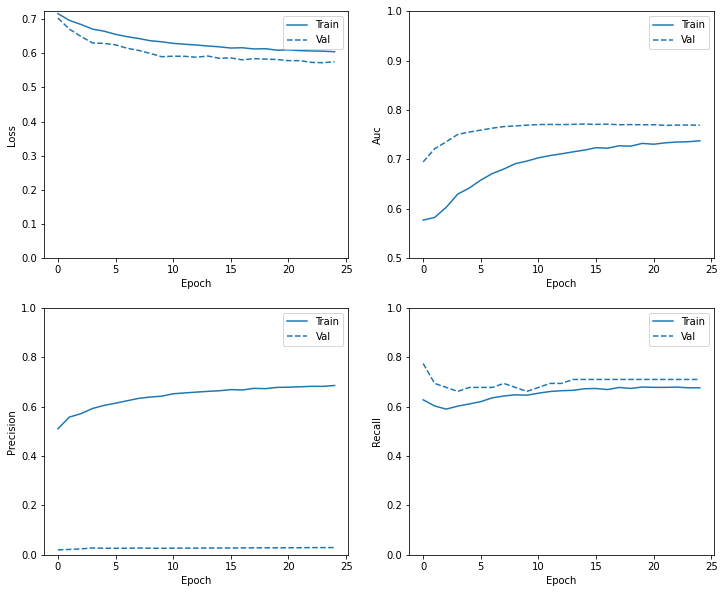

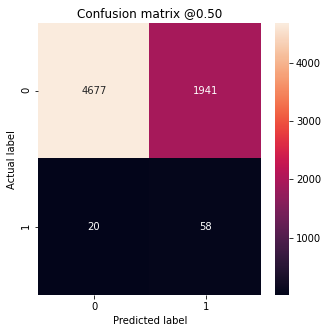

In [58]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='sigmoid', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
                            ])
        
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics
                 )

    return model



# Re-training

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


# Re-check training history
plot_metrics(resampled_history)


# Evaluate metrics

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Epoch 1/10000
20/20 [==============================] - 2s 88ms/step - loss: 0.7612 - tp: 27569.0000 - fp: 26164.0000 - tn: 21648.0000 - fn: 13235.0000 - accuracy: 0.5554 - precision: 0.5131 - recall: 0.6756 - auc: 0.5908 - val_loss: 0.8206 - val_tp: 45.0000 - val_fp: 3170.0000 - val_tn: 2125.0000 - val_fn: 17.0000 - val_accuracy: 0.4051 - val_precision: 0.0140 - val_recall: 0.7258 - val_auc: 0.6172
Epoch 2/10000
20/20 [==============================] - 1s 49ms/step - loss: 0.7583 - tp: 27743.0000 - fp: 23928.0000 - tn: 16888.0000 - fn: 13361.0000 - accuracy: 0.5448 - precision: 0.5369 - recall: 0.6749 - auc: 0.5673 - val_loss: 0.8170 - val_tp: 45.0000 - val_fp: 3164.0000 - val_tn: 2131.0000 - val_fn: 17.0000 - val_accuracy: 0.4062 - val_precision: 0.0140 - val_recall: 0.7258 - val_auc: 0.6171
Epoch 3/10000
20/20 [==============================] - 1s 52ms/step - loss: 0.7569 - tp: 27387.0000 - fp: 23837.0000 - tn: 17064.0000 - fn: 13632.0000 - accuracy: 0.5426 - precision: 0.5347 - reca

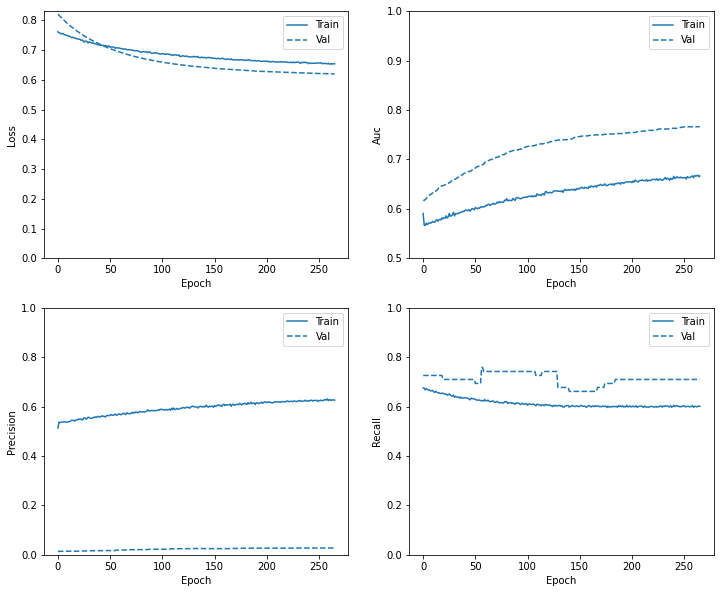

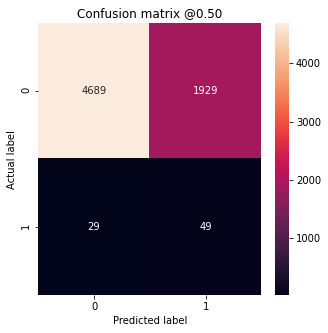

In [59]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
                            ])
        
    model.compile(optimizer=keras.optimizers.SGD(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics
                 )

    return model



# Re-training

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


# Re-check training history
plot_metrics(resampled_history)


# Evaluate metrics

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Epoch 1/10000
20/20 [==============================] - 2s 83ms/step - loss: 0.7406 - tp: 22717.0000 - fp: 21555.0000 - tn: 26257.0000 - fn: 18087.0000 - accuracy: 0.5527 - precision: 0.5131 - recall: 0.5567 - auc: 0.5662 - val_loss: 0.7058 - val_tp: 34.0000 - val_fp: 2316.0000 - val_tn: 2979.0000 - val_fn: 28.0000 - val_accuracy: 0.5624 - val_precision: 0.0145 - val_recall: 0.5484 - val_auc: 0.6046
Epoch 2/10000
20/20 [==============================] - 1s 44ms/step - loss: 0.7394 - tp: 23204.0000 - fp: 19566.0000 - tn: 21250.0000 - fn: 17900.0000 - accuracy: 0.5427 - precision: 0.5425 - recall: 0.5645 - auc: 0.5567 - val_loss: 0.7055 - val_tp: 35.0000 - val_fp: 2372.0000 - val_tn: 2923.0000 - val_fn: 27.0000 - val_accuracy: 0.5522 - val_precision: 0.0145 - val_recall: 0.5645 - val_auc: 0.6069
Epoch 3/10000
20/20 [==============================] - 1s 49ms/step - loss: 0.7421 - tp: 22997.0000 - fp: 19653.0000 - tn: 21248.0000 - fn: 18022.0000 - accuracy: 0.5401 - precision: 0.5392 - reca

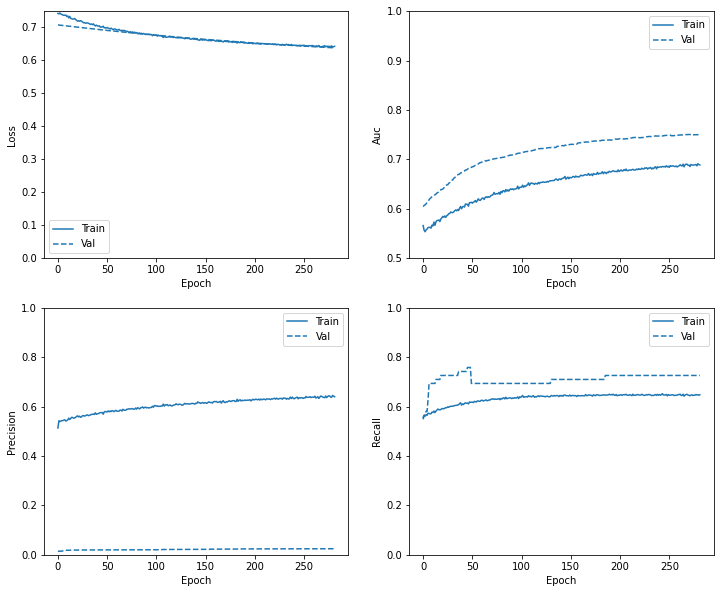

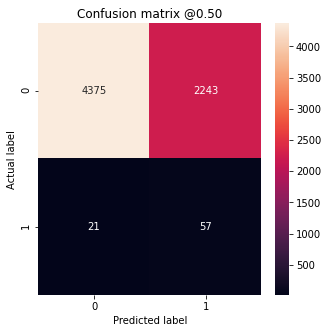

In [60]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='tanh', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
                            ])
        
    model.compile(optimizer=keras.optimizers.SGD(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics
                 )

    return model



# Re-training

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


# Re-check training history
plot_metrics(resampled_history)


# Evaluate metrics

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Epoch 1/10000
20/20 [==============================] - 2s 84ms/step - loss: 0.7335 - tp: 26936.0000 - fp: 27986.0000 - tn: 19826.0000 - fn: 13868.0000 - accuracy: 0.5277 - precision: 0.4904 - recall: 0.6601 - auc: 0.5536 - val_loss: 0.7963 - val_tp: 56.0000 - val_fp: 4686.0000 - val_tn: 609.0000 - val_fn: 6.0000 - val_accuracy: 0.1241 - val_precision: 0.0118 - val_recall: 0.9032 - val_auc: 0.5920
Epoch 2/10000
20/20 [==============================] - 1s 43ms/step - loss: 0.7328 - tp: 27029.0000 - fp: 25405.0000 - tn: 15411.0000 - fn: 14075.0000 - accuracy: 0.5181 - precision: 0.5155 - recall: 0.6576 - auc: 0.5255 - val_loss: 0.7931 - val_tp: 55.0000 - val_fp: 4537.0000 - val_tn: 758.0000 - val_fn: 7.0000 - val_accuracy: 0.1518 - val_precision: 0.0120 - val_recall: 0.8871 - val_auc: 0.5934
Epoch 3/10000
20/20 [==============================] - 1s 47ms/step - loss: 0.7314 - tp: 26888.0000 - fp: 25169.0000 - tn: 15732.0000 - fn: 14131.0000 - accuracy: 0.5203 - precision: 0.5165 - recall: 

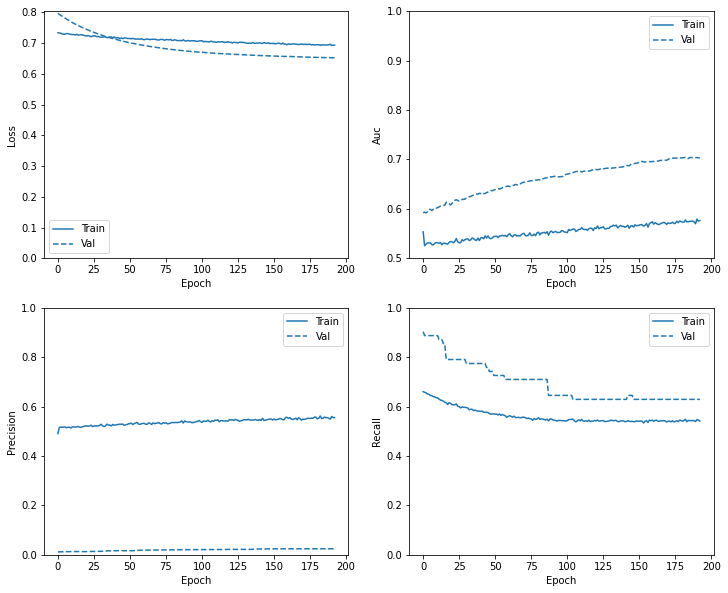

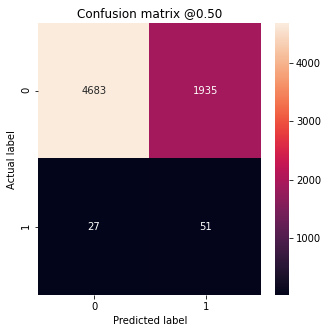

In [61]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='sigmoid', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
                            ])
        
    model.compile(optimizer=keras.optimizers.SGD(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics
                 )

    return model



# Re-training

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


# Re-check training history
plot_metrics(resampled_history)


# Evaluate metrics

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

# FEATURES

In [76]:
# Again the better model

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='sigmoid', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
                            ])
        
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics
                 )

    return model



# Re-training

resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))


# Evaluate metrics

train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)


Epoch 1/10000
20/20 [==============================] - 2s 81ms/step - loss: 0.7171 - tp: 25447.0000 - fp: 24822.0000 - tn: 22990.0000 - fn: 15357.0000 - accuracy: 0.5466 - precision: 0.5062 - recall: 0.6236 - auc: 0.5743 - val_loss: 0.7017 - val_tp: 48.0000 - val_fp: 2370.0000 - val_tn: 2925.0000 - val_fn: 14.0000 - val_accuracy: 0.5550 - val_precision: 0.0199 - val_recall: 0.7742 - val_auc: 0.6951
Epoch 2/10000
20/20 [==============================] - 1s 44ms/step - loss: 0.6973 - tp: 24515.0000 - fp: 19637.0000 - tn: 21179.0000 - fn: 16589.0000 - accuracy: 0.5578 - precision: 0.5552 - recall: 0.5964 - auc: 0.5804 - val_loss: 0.6704 - val_tp: 43.0000 - val_fp: 1924.0000 - val_tn: 3371.0000 - val_fn: 19.0000 - val_accuracy: 0.6373 - val_precision: 0.0219 - val_recall: 0.6935 - val_auc: 0.7228
Epoch 3/10000
20/20 [==============================] - 1s 45ms/step - loss: 0.6840 - tp: 24381.0000 - fp: 18297.0000 - tn: 22604.0000 - fn: 16638.0000 - accuracy: 0.5735 - precision: 0.5713 - reca

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.98775
Feature: 2, Score: 0.43184
Feature: 3, Score: -0.01506
Feature: 4, Score: -0.22117
Feature: 5, Score: -0.05289
Feature: 6, Score: 0.37440
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.11814
Feature: 9, Score: 0.02308
Feature: 10, Score: -0.78663
Feature: 11, Score: 0.19896
Feature: 12, Score: 0.00000
Feature: 13, Score: -0.52686
Feature: 14, Score: 0.24054
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.27620
Feature: 18, Score: -0.23310
Feature: 19, Score: 0.02825
Feature: 20, Score: -0.38453
Feature: 21, Score: 0.17749
Feature: 22, Score: 0.79485
Feature: 23, Score: 0.00000
Feature: 24, Score: -0.57075
Feature: 25, Score: 1.34017
Feature: 26, Score: -0.10521
Feature: 27, Score: 0.38154


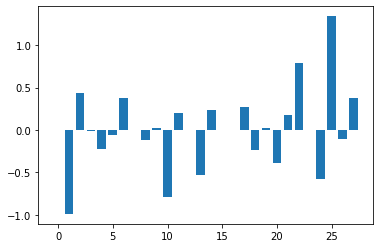

Index(['type_road_intersection', 'type_road_land_lot', 'type_road_other',
       'type_road_track_section', 'climate_wet', 'weekend_yes', 'night_yes',
       'street_use_one_way', 'street_use_other', 'street_use_two_ways',
       'number_roads_one_road', 'number_roads_other', 'number_roads_two_roads',
       'number_lanes_one_lane', 'number_lanes_other', 'number_lanes_two_lanes',
       'rolling_surface_other', 'status_road_bad', 'illumination_bad',
       'traffic_light_bad', 'vertical_signals_bad', 'horizontal_signals_bad',
       'visibility_bad', 'type_vehicle_car', 'type_vehicle_motorcycle',
       'type_vehicle_other', 'month_dry_no', 'humidity_road_other',
       'severity'],
      dtype='object')


In [ ]:
import juan_code as jc

importance = jc.get_features(model)

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
print(df.columns)